In [2]:
import os
import sys
sys.path.append("..")
import matplotlib
%matplotlib notebook
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import ipywidgets as widgets
from IPython.display import display
import numpy as np
from LowLevelModules.GeneralFunctions import get_work_dir, MyPlot, TRMData
from LowLevelModules.GeneralFunctions import TRMData
from scipy.signal import convolve
from scipy.optimize import curve_fit

In [3]:
from matplotlib.pyplot import subplots

#other functions
def exp_fold(xe, amp, gamma, t_shift):
    return (1 + 1/(np.exp(gamma * t_laser) - 1)) * amp * np.exp(-gamma*(xe-t_shift))
    
def Decay_1_exp(xd, a1, g1, bg, t0):
    fit_raw = exp_fold(xd, a1, g1, t0) + bg 
    return fit_raw

def Decay_2_exp(xd, a1, g1, a2, g2, bg, t0):
    # take into account folding of data in form of exponential series
    exp1 = exp_fold(xd, a1, g1, t0)
    exp2 = exp_fold(xd, a2, g2, t0)
    fit_raw = bg + exp1 + exp2
    # convolve with IRF
    fit_conv = convolve(fit_raw, irf.y,'same') / sum(irf.y)
    return fit_conv

def Decay_3_exp(xd, a1, g1, a2, g2, a3, g3, bg, t0):
    # take into account folding of data in form of exponential series
    exp1 = exp_fold(xd, a1, g1, t0)
    exp2 = exp_fold(xd, a2, g2, t0)
    exp3 = exp_fold(xd, a3, g3, t0)
    fit_raw = bg + exp1 + exp2 + exp3
    # convolve with IRF
    #fit_conv = signal.convolve(raw_fit, irf.y,'same') / sum(irf.y)
    return fit_raw

In [37]:
wdir = r"Z:\Projects\WSe2\2020\02 february\20200224 - WSe2 hBN gated\5K data\lifetime"

filenames = [f[:-4] for f in os.listdir(wdir) if '.sdt' in f]
file_choice = widgets.RadioButtons(options=filenames,
                                     value=filenames[0],
                                     description='file')
display(file_choice)

RadioButtons(description='file', options=('WSe2hBN_TRM_spotTBD_760nW_728exc', 'WSe2hBN_TRM_spotTBD_140nW_728ex…

<IPython.core.display.Javascript object>


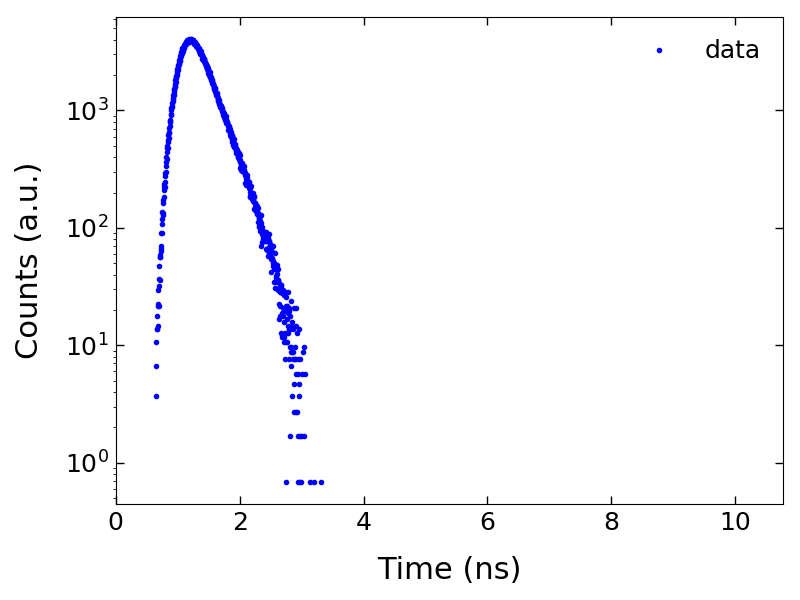

In [42]:
import warnings
warnings.simplefilter(action = "ignore", category = RuntimeWarning)

sdt_data_path = wdir + '//' + file_choice.value + '.sdt'
data = TRMData(sdt_data_path)

bckg_path = r'Z:\Projects\WSe2\2020\02 february\background_2020_02_12.sdt'
bckg = TRMData(bckg_path)

irf_path = r"Z:\Projects\WSe2\2020\02 february\IRF_mira_60kHz.sdt"
irf = TRMData(irf_path)

#remove background contribution
bckg_rate = np.mean(bckg.y) / bckg.col_t
data.y = data.y - bckg_rate * data.col_t

#rescale IRF data
irf.y = irf.y / np.sum(irf.y) # np.max(irf.y) * np.max(data.y)

#fitting
t_laser = 1e9 / irf.laser_rep_rate
t_start = 1.3
idx = data.x>t_start
data_trunc_x = data.x[idx]
data_trunc_y = data.y[idx]
irf_trunc = irf.y[irf.y>1e-7]

## choose fitting function
func = Decay_1_exp
## start guesses
fast_rate_guess = np.max(data.y) / np.mean(data.y)
slow_rate_guess = .05 * np.max(data.y) / np.mean(data.y)
A_fast_guess = np.max(data.y)
A_slow_guess = np.mean(data.y)
p00 = ([A_fast_guess, fast_rate_guess, 0 , 0])
#p00 = ([650, 0.06, 0, 0])
#p00 = ([A_fast_guess, fast_rate_guess, A_slow_guess, slow_rate_guess, 0 , 0])
bds = ([0, 0, 0 , 0], [np.inf, np.inf, np.inf, np.inf])
#bds = ([0, 0, 0, 0, -np.inf, -np.inf], [np.inf, np.inf, np.inf, np.inf, np.inf, np.inf])
# do the fit
coeffs, _ = curve_fit(func, data_trunc_x, data_trunc_y, p0=p00, bounds=bds)
y_fit = func(data_trunc_x, *coeffs)
# coeffs = (650, 0.06, 0, 0)
# y_fit = func(data_trunc_x, *coeffs)

pl = MyPlot(1, 1, xlabel='Time (ns)', ylabel='Counts (a.u.)')
pl.semilogy(data.x, data.y, 'bo', markersize=3, label='data')
#pl.semilogy(irf.x, irf.y, 'g', label='IRF')
#pl.semilogy(data_trunc_x, y_fit, 'r', label='fit')
#pl.ax.set_ylim([0.95*np.min(data.y), 1.1*np.max(data.y)])
pl.ax.legend(prop={'size': 18}, frameon=False)
# pl.ax.text(8, 0.4*np.max(data.y), f"γf = {np.round(coeffs[1],3)} ns-1", size='x-large')
# pl.ax.text(8, 0.3*np.max(data.y), f"γs = {np.round(coeffs[3],3)} ns-1", size='x-large')
plt.tight_layout()
#pl.fig.savefig(wdir + '\\' + file_choice.value + '.png', format='png', bbox_inches='tight')

In [33]:
1/coeffs[1]

17.953524283503718

In [7]:
import plotly.express as px
import plotly.graph_objs as go

In [8]:
from plotly.offline import iplot, init_notebook_mode
init_notebook_mode(connected = True)

def go_layout():
    lay = go.Layout(title="Sine wave")
    return

def go_plot(xdata, ydata):
    data = go.Scatter(x=xdata, y=ydata)
    return {'data': [data]}

pl = go_plot(data.x, data.y)
iplot(pl)

In [9]:
import pandas as pd
df = pd.DataFrame({'Time (ns)': data.x, 'Counts (a.u.)': data.y, 'IRF': irf.y})
fig = px.scatter(df, x="Time (ns)", y="Counts (a.u.)", log_y=True,  template="plotly_dark")
iplot(fig)

ValueError: arrays must all be same length